

> The results obtained from the model was different during every execution.`But the accuracy seems to be consistent (around 85% -95%).` Try increasing the number of images. The epochs for whuch the model was trained till now was:5,20 but increasing the steps from 50 to 75.









In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf

#from data import *

from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.optimizers import *
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras import backend as keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau#
import matplotlib.pyplot as plt
import pickle


Using TensorFlow backend.


In [0]:
#data augumentation 
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args,rescale=1.0/255.0)   #normaliztion for original image
seed = 1
mask_datagen = ImageDataGenerator(**data_gen_args,rescale=1.0/255.0)     #normalization for mask image 

In [0]:
#generator = image_datagen.flow_from_directory('/content/drive/My Drive/original',target_size=(256,256),save_to_dir='/content/drive/My Drive/mask',class_mode=None,save_prefix='N',save_format='png',color_mode="grayscale")

In [0]:
#original image generator 
image_generator = image_datagen.flow_from_directory(
             '/content/drive/My Drive/projectdataset/Original_GE',
             target_size=(256,256),
             seed=seed,
             class_mode=None,
            color_mode='grayscale')
    

Found 70 images belonging to 1 classes.


In [0]:
#mask image generator 
mask_generator = mask_datagen.flow_from_directory(
        '/content/drive/My Drive/projectdataset/Mask_GE',
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        color_mode='grayscale')

Found 70 images belonging to 1 classes.


In [0]:
validation_mask_generator = mask_datagen.flow_from_directory(
        '/content/drive/My Drive/projectdataset/validation_mask',
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        color_mode='grayscale')

Found 20 images belonging to 1 classes.


In [0]:
validation_image_generator = image_datagen.flow_from_directory(
             '/content/drive/My Drive/projectdataset/validation_original',
             target_size=(256,256),
             seed=seed,
             class_mode=None,
            color_mode='grayscale')

Found 20 images belonging to 1 classes.


In [0]:
def my_image_mask_generator(image_data_generator, mask_data_generator):

  validation_generator = zip(validation_image_generator, validation_mask_generator)
  for (img, mask) in validation_generator:
        yield (img, mask)  

val_generator = my_image_mask_generator(validation_image_generator,validation_mask_generator)
print(val_generator)

<generator object my_image_mask_generator at 0x7f5ed29aec50>


In [0]:
  #combining the original and mask into another new generator to feed it into the model
def my_image_mask_generator(image_data_generator, mask_data_generator):

  train_generator = zip(image_generator, mask_generator)
  for (img, mask) in train_generator:
        yield (img, mask)  

mygen = my_image_mask_generator(image_generator,mask_generator)
print(mygen)

<generator object my_image_mask_generator at 0x7f5ed68a2d58>


In [0]:
#for the purpose of testing 

test_generator = image_datagen.flow_from_directory(
             '/content/drive/My Drive/projectdataset/test',
             target_size=(256,256),
             seed=seed,
             
            color_mode='grayscale')

Found 23 images belonging to 1 classes.


In [3]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [4]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr=1e-4), loss =dice_coef_loss, metrics = ['accuracy',dice_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model



In [5]:
model = unet()

NameError: name 'Input' is not defined

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
history=model.fit_generator(mygen,steps_per_epoch=75,epochs=20,verbose=1,validation_data=val_generator,validation_steps=10)  

Epoch 1/20
75/75 [==============================] - 61s 818ms/step - loss: -0.0848 - acc: 0.9501 - dice_coef: 0.0848 - val_loss: -0.0681 - val_acc: 0.9261 - val_dice_coef: 0.0681
Epoch 2/20
75/75 [==============================] - 59s 789ms/step - loss: -0.0857 - acc: 0.9437 - dice_coef: 0.0857 - val_loss: -0.0692 - val_acc: 0.9229 - val_dice_coef: 0.0692
Epoch 3/20
75/75 [==============================] - 59s 789ms/step - loss: -0.0879 - acc: 0.9523 - dice_coef: 0.0879 - val_loss: -0.0793 - val_acc: 0.9366 - val_dice_coef: 0.0793
Epoch 4/20
75/75 [==============================] - 59s 789ms/step - loss: -0.0885 - acc: 0.9626 - dice_coef: 0.0885 - val_loss: -0.0797 - val_acc: 0.9397 - val_dice_coef: 0.0797
Epoch 5/20
75/75 [==============================] - 59s 789ms/step - loss: -0.0884 - acc: 0.9575 - dice_coef: 0.0884 - val_loss: -0.0765 - val_acc: 0.9352 - val_dice_coef: 0.0765
Epoch 6/20
34/75 [============>.................] - ETA: 31s - loss: -0.0881 - acc: 0.9557 - dice_coef: 0

In [0]:
def plot_learningCurve(history, epoch):
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['acc'])
  plt.plot(epoch_range, history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history,20)

NameError: ignored

In [0]:
import matplotlib.pyplot as plt
import numpy as np

1/1 [==============================] - 10s 10s/step


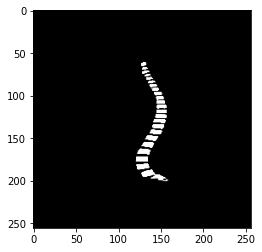

In [0]:
y_pred=model.predict_generator(test_generator,verbose=1) 
y_pred.shape
imgs=np.resize(y_pred,(256,256))
plt.imshow(imgs,cmap='gray')




1/1 [==============================] - 0s 39ms/step


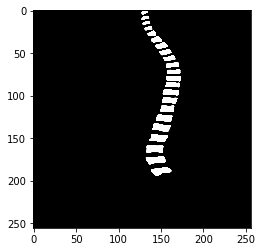

In [0]:
y_pred=model.predict(train_generator,verbose=1) 
y_pred.shape
imgs=np.resize(y_pred,(256,256))
plt.imshow(imgs,cmap='gray')

In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
#to get a test image of size (128,128,1)
import cv2
img=cv2.imread('/content/drive/My Drive/projectdataset/Original_GE/original (1)/02(orig).png')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
width = 128
height = 128
dim = (width, height)
 
# resize image
resized = cv2.resize(gray_image, dim, interpolation = cv2.INTER_AREA) 
y = np.expand_dims(resized, axis=-1)
print(y.shape)
#resized.shape
cv2.imwrite('/content/drive/My Drive/projectdataset/Original_GE/Trial03.png',y)


(128, 128, 1)


True

In [0]:
hell=cv2.imread('/content/drive/My Drive/projectdataset/Original_GE/trial.png')
hell.shape

(512, 512, 3)

In [0]:
trial=cv2.imread('/content/drive/My Drive/projectdataset/Original_GE/02(orig)trial.png')
trial.shape

(128, 128, 3)

In [0]:
tf.__version__

'1.15.0'

In [0]:
import os

In [0]:
model.save('/content/drive/My Drive/projectdataset/spine_model_validation.h5')

In [0]:
model.save('my_model_validation.h5')

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
#tf.enable_v2_behavior()

## Cells below this are for experimental purpose


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
model.fit(validation_split)

In [0]:
y_pred =model.predict("\")
plt.imshow(y_pred,cmap='grayscale')

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
tf.global_variables_initializer

<function tensorflow.python.ops.variables.global_variables_initializer>